<a href="https://colab.research.google.com/github/ChloeMorgana/Dissertation-Project/blob/main/PubMedBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Loading of DrugProt dataset

Downloading and unzipping file

In [ ]:
!wget https://zenodo.org/record/5042151/files/drugprot-gs-training-development.zip
!unzip drugprot-gs-training-development.zip

--2022-12-27 10:54:17--  https://zenodo.org/record/5042151/files/drugprot-gs-training-development.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3796908 (3.6M) [application/octet-stream]
Saving to: ‘drugprot-gs-training-development.zip.1’

drugprot-gs-trainin 100%[===================>]   3.62M  2.11MB/s    in 1.7s    

2022-12-27 10:54:21 (2.11 MB/s) - ‘drugprot-gs-training-development.zip.1’ saved [3796908/3796908]

Archive:  drugprot-gs-training-development.zip
replace drugprot-gs-training-development/README.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Combining all three files together.

In [ ]:
def loadDrugProt(abstracts_filename, entities_filename, relations_filename):

  docs = {}

  # Load the title/abstracts text in as documents
  with open(abstracts_filename, encoding='utf8') as f:
    for lineno,line in enumerate(f):
      split = line.strip('\n').split('\t')
      assert len(split) == 3, f"Expected 3 columns but got {len(split)} on line {lineno+1}"
      pubmed_id, title, abstract = split
      pubmed_id = int(pubmed_id)

      combined_text = title + '\n' + abstract
      docs[pubmed_id] = {'pubmed_id':pubmed_id, 'text':combined_text, 'entities':{}, 'relations':[]}

  # Load the entities and match them up with the documents
  with open(entities_filename, encoding='utf8') as f:
    for lineno,line in enumerate(f):
      split = line.strip('\n').split('\t')
      assert len(split) == 6, f"Expected 6 columns but got {len(split)} on line {lineno+1}"
      pubmed_id, entity_id, entity_type, start_coord, end_coord, entity_text = split

      pubmed_id = int(pubmed_id)
      start_coord = int(start_coord)
      end_coord = int(end_coord)

      assert pubmed_id in docs, f"Did not find matching document for pubmed_id={pubmed_id}"
      doc = docs[pubmed_id]

      assert doc['text'][start_coord:end_coord] == entity_text, f"Text for entity with coords {start_coord}:{end_coord} in document (pubmed_id={pubmed_id} does not match expected. 'f{doc['text'][start_coord:end_coord]}' != '{entity_text}'"

      entity = {'type':entity_type, 'start':start_coord, 'end':end_coord, 'text':entity_text}
      doc['entities'][entity_id] = entity

  if relations_filename is not None:
    # Load the relations and match them up with the entities in the corresponding document
    with open(relations_filename, encoding='utf8') as f:
      for lineno,line in enumerate(f):
        split = line.strip('\n').split('\t')
        assert len(split) == 4, f"Expected 4 columns but got {len(split)} on line {lineno+1}"

        pubmed_id, relation_type, arg1, arg2 = split

        pubmed_id = int(pubmed_id)
        assert arg1.startswith('Arg1:'), f"Relation argument should start with 'Arg1:'. Got: {arg1}"
        assert arg2.startswith('Arg2:'), f"Relation argument should start with 'Arg2:'. Got: {arg2}"

        # Remove arg1/arg2 from text
        arg1 = arg1.split(':')[1]
        arg2 = arg2.split(':')[1]

        assert pubmed_id in docs, f"Did not find matching document for pubmed_id={pubmed_id}"
        doc = docs[pubmed_id]

        assert arg1 in doc['entities'], f"Couldn't find entity with id={arg1} in document with pubmed_id={pubmed_id}"
        assert arg2 in doc['entities'], f"Couldn't find entity with id={arg2} in document with pubmed_id={pubmed_id}"

        relation = {'type':relation_type,'arg1':arg1,'arg2':arg2}
        doc['relations'].append(relation)

  # Convert the dictionary of documents (indexed by pubmed_id) into a simpler dictionary
  docs = sorted(docs.values(), key=lambda x:x['pubmed_id'])

  return docs

Applying function to dataset

In [ ]:
docs = loadDrugProt('drugprot-gs-training-development/training/drugprot_training_abstracs.tsv',
                    'drugprot-gs-training-development/training/drugprot_training_entities.tsv',
                    'drugprot-gs-training-development/training/drugprot_training_relations.tsv')

Observation of doc structure


In [ ]:
search = [ d for d in docs if d['pubmed_id'] == 23197773]
#find = [ d for d in docs if "This study was designed to establish initial safety and efficacy data in essential hypertension for this novel class of drug." in d['text'] ]
#assert len(search) == 1, "Something went wrong and couldn't find the document we want"


non_sent = [ d for d in docs if d['pubmed_id'] == 8733007]
non_sent
#doc = search
#print(doc)

docs.remove(search[0])
#find

We can observe the total number of relations and the number of different relation types across all documents below:

In [ ]:
num = 0
labs = list(set([r['type'] for doc in docs for r in doc['relations']]))
rels = {}
for l in labs:
  rels[l] = 0

for doc in docs:
  num += len(doc['relations'])
  for r in doc['relations']:
    rels[r['type']]+=1
  

print(f"Number of total relations: {num}")
for k,v in rels.items():
  print(f"Number of relations for {k} is: {v}")

Number of total relations: 17273
Number of relations for DIRECT-REGULATOR is: 2250
Number of relations for ANTAGONIST is: 968
Number of relations for ACTIVATOR is: 1429
Number of relations for SUBSTRATE is: 2003
Number of relations for INHIBITOR is: 5392
Number of relations for SUBSTRATE_PRODUCT-OF is: 25
Number of relations for PART-OF is: 886
Number of relations for AGONIST is: 648
Number of relations for INDIRECT-DOWNREGULATOR is: 1330
Number of relations for AGONIST-INHIBITOR is: 13
Number of relations for INDIRECT-UPREGULATOR is: 1379
Number of relations for AGONIST-ACTIVATOR is: 29
Number of relations for PRODUCT-OF is: 921


# Encoding Step

The code below imports certain packages that will be used during this relation extraction task.

In [ ]:
#!pip install torch
!pip install transformers
!pip install segtok

#import transformers as ppb
from transformers import BertModel, AutoTokenizer
import pandas as pd
import numpy as np
import nltk
import torch
import itertools
from segtok.segmenter import split_single

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


This is a function that checks if a particular entity tag is part of a relation or not. This is used to form labels for the data so that the classifier can learn which sentences contain relations and which do not.

In [38]:
# Checks if the entity specified belongs to one term in the relation
def isRelation(doc, key):

  relations = doc['relations']
  for r in relations:
    #Checks if the entity is involved in any part of a specified relation
    if (key == r['arg1']) or (key == r['arg2']):
      #Returns the name of the relation and a boolean value
      return True, r['type']
  return False, 0

#Checks if both arguments are terms in one relation
def isEntityRelation(arg1,arg2,doc):
  relation = 0
  for r in doc['relations']:
    if (arg1 == r['arg1']) and (arg2 == r['arg2']):
      return True, r['type']
  return False, 0


This function takes in the text and finds all of the labels for all pairs of entity relations. This will be used later to input into the classifier.

In [40]:
def find_sent_idxs(text):
  idxs = [0]
  idx = 0
  split_text = split_single(text)
  for t in split_text:
    idx += len(t)+1
    idxs.append(idx)
  return idxs

def find_entity_labels(idxs, keys, doc):
  labels = []
  rel_labels= []
  entity_dict = {}
  processed_entities = set()

  for i in idxs:
    entity_dict[i]=[]

  for key in keys:
    if key in processed_entities:  # skip entity if it has already been processed
      continue
    for i in range(len(idxs)-1):
      s = doc['entities'][key]['start']
      e = doc['entities'][key]['end']
      if (s >= idxs[i] and s < idxs[i+1]) and (e > idxs[i] and e <= idxs[i+1]):
        #print(f"First idx: {idxs[i]}, middle idx: {doc['entities'][key]['start']} {doc['entities'][key]['end']}, second idx: {idxs[i+1]}, ")
        entity_dict[idxs[i]].append(key)
      elif (s >= idxs[i] and s < idxs[i+1]) and (e > idxs[i] and e >= idxs[i+1]):
        print(doc['entities'][key]['text'])
        print(f"First idx: {idxs[i]}, middle idx: {doc['entities'][key]['start']} {doc['entities'][key]['end']}, second idx: {idxs[i+1]}, ")
        
  for k, v in entity_dict.items():
    #print(k)
    if not v==[]:
      #print(v)
      chems = []
      genes = []
      for name in v:
        if doc['entities'][name]['type'] == 'CHEMICAL':
          chems.append(name)
        else:
          #print(doc['entities'][name]['type'])
          genes.append(name)

      #print(f'chems: {chems}, genes: {genes}')
      #if chems!=[] and genes!=[]:
      prods = itertools.product(chems,genes)
      for prod in prods:
        #print(prod)
        #print(prod[0])
        b, r = isEntityRelation(prod[0],prod[1],doc)
        if b:
          rel_labels.append(r)
          labels.append(1)
        else:
          #print(f'Prod 0: {prod[0]}, prod 1: {prod[1]}')
          rel_labels.append(0)
          labels.append(0)
  

  return labels, rel_labels

This function adds in start and end entity tags to biomedical text. This ensures that every chemical mentioned is encased in [E1][/E1] tags, and every gene is encased in [E2][/E2] tags, so that we can extract the embeddings for these later.

In [43]:
def addEntityTags(docs):

  for doc in docs:
    #Contains the labels for each sentence (1 for positive result, 0 for no relation)
    doc['labels'] = []
    #Contains more explicit names for the relations.
    doc['classes'] = []

    str = ''
    index = 0

    #Contains every mention of chemicals and genes for a particular document
    keys = doc['entities'].keys()

    #Makes sure the indices of these mentions are in order
    key_list = sorted(keys, key= lambda x: (doc['entities'][x]['start']))

    #Finds the indexes of the start and end of each sentence in the text
    idxs = find_sent_idxs(doc['text'])
    #print(idxs)


    l,r = find_entity_labels(idxs, key_list, doc)
    doc['entity_labels'] = l
    doc['rel_labels'] = r
    #print(l)
    #print(find_entity_labels(idxs, keys, doc))

    for k in key_list:
      #Adds a 1 to the list of labels if it is a positive result, 0 if negative
      b,r = isRelation(doc,k)
      if b:
        doc['labels'].append(1)
      else:
        doc['labels'].append(0)
      doc['classes'].append(r)
      v = doc['entities'][k]

      #Start and end indexes of entity
      start = v['start']
      end = v['end']
      name = doc['text'][start:end]
      name = name.replace('.', ' ')

      if v['type'] == 'CHEMICAL':
        str += doc['text'][index:start] + ' [E1] ' + name + ' [/E1]'
      else:
        str += doc['text'][index:start] + ' [E2] ' + name + ' [/E2]'
      index = end
    
    #Adds the tagged text to the dictionary of a particular document
    doc['tagged_text'] = str 

addEntityTags(docs)

print(docs[0].keys())
print(docs[0]['entities'])
print(docs[0]['entity_labels'])
print(docs[0]['rel_labels'])
print(docs[0]['tagged_text'])



SUR1. 6
First idx: 1008, middle idx: 1069 1076, second idx: 1075, 
E.C. 1.14.11.2
First idx: 436, middle idx: 652 666, second idx: 657, 
Enc. cuniculi PAO
First idx: 1221, middle idx: 1225 1242, second idx: 1230, 
Bacillus circulans ssp. alkalophilus phosphoserine aminotransferase
First idx: 0, middle idx: 47 114, second idx: 71, 
rat brain. LDH1
First idx: 975, middle idx: 1140 1155, second idx: 1151, 
Anabaena sp. CH1 N-acetyl-D-glucosamine 2-epimerase
First idx: 0, middle idx: 79 130, second idx: 92, 
Anabaena sp. CH1 N-acetyl-d-glucosamine 2-epimerase
First idx: 336, middle idx: 399 450, second idx: 412, 
dict_keys(['pubmed_id', 'text', 'entities', 'relations', 'labels', 'classes', 'entity_labels', 'tagged_text', 'rel_labels'])
{'T1': {'type': 'CHEMICAL', 'start': 1455, 'end': 1466, 'text': 'benzamidine'}, 'T2': {'type': 'CHEMICAL', 'start': 1489, 'end': 1493, 'text': 'EACA'}, 'T3': {'type': 'CHEMICAL', 'start': 292, 'end': 298, 'text': 'lysine'}, 'T4': {'type': 'CHEMICAL', 'start'

Next, we can reduce the text to only sentences potentially containing relations between chemicals and genes by splitting the sentences and seeing if there are any entity tags present within the sentence. The findLabels function goes through the list of labels for a particular document and sees if there is a relation present within that sentence.

(Note for later: I didn't take into account relations across sentences in this implementation, will have to change something to ensure that both entities for one relation are in the same sentence)

In [ ]:
from collections import Counter

def relevantText():

  target_text = []
  labels = []
  classes = []

  for doc in docs:
    txt = doc['tagged_text']
    lbls = doc['labels']

    split_text = []
    split_text += split_single(txt)
    offset = 0

    for s in range(len(split_text)):
      if ('[E1]' in split_text[s] and '[/E1]' in split_text[s]) or ('[E2]' in split_text[s] and '[/E2]' in split_text[s]):
        o, l, new_lbls = findLabels(split_text[s],lbls,offset)
        target_text.append(split_text[s])
        lbls = new_lbls
        offset += o
        labels.append(l)
      elif '[/E' in split_text[s] or '[E1]' in split_text[s]  or '[E2]' in split_text[s]:
        
        print(split_text[s])
        print(f"Previous sentence: {split_text[s-1]}")
        print(f"Next sentence: {split_text[s+1]}")
        print()
  
  return target_text, labels, classes

def findLabels(text, labels, offset=0):
    words = text.split(" ")
    counter = Counter(words)
    idx = counter['[E2]']+counter['[E1]']
    isRel = False
    for i in range(idx):
      if labels[i]==1:
        isRel = True
    offset+=idx
    if isRel:
      label = 1
    else:
      label = 0
    l = labels[idx:]
    return offset, label, l

target_text, labels, classes = relevantText()

#Both the target text and the labels must be the same length
print(len(target_text))
print(len(labels))



29242
29242


There are around 17288 total relations, therefore there some sentences that contain entities but don't actually contain a relation. The code below shows a snippet of the target text which should only contain sentences that contain tagged entities. It also contains the first five labels which are all 0 in this case. These seems sensible as there isn't a chemical in the first sentence, and therefore there is no relationship specified between a chemical and gene.

In [ ]:
print(target_text[:12])
print(labels[:22])

['Analysis of  [E2] plasmin [/E2] binding and  [E2] urokinase [/E2] activation of  [E2] plasminogen [/E2] bound to the  [E2] Heymann nephritis autoantigen [/E2],  [E2] gp330 [/E2].', 'Previously, we demonstrated that the  [E2] Heymann nephritis autoantigen [/E2],  [E2] gp330 [/E2], can serve as a receptor site for  [E2] plasminogen [/E2].', 'This binding was not significantly inhibited by the  [E1] lysine [/E1] analogue  [E1] epsilon-amino caproic acid [/E1] ( [E1] EACA [/E1]), indicating that  [E2] plasminogen [/E2] binding was not just through  [E1] lysine [/E1] binding sites as suggested for other  [E2] plasminogen [/E2] binding sites.', 'We now report that once  [E2] plasminogen [/E2] is bound to  [E2] gp330 [/E2], it can be converted to its active form of  [E2] plasmin [/E2] by  [E2] urokinase [/E2].', 'This conversion of  [E2] plasminogen [/E2] to  [E2] plasmin [/E2] proceeds at a faster rate when  [E2] plasminogen [/E2] is first prebound to  [E2] gp330 [/E2].', 'Although there i

# Embedding Step

Next, a BERT model is defined that has been pre-trained using PubMed texts. This allows BERT to recognise biomedical terms within the text and understand their context better.

The tokeniser is also defined using pubmed texts, and special tokens are added in so that BERT can recognise them and not break them down when tokenising.

In [ ]:
model = BertModel.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
                                  output_hidden_states = True,
                                  )

tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext") 

tokenizer.add_tokens(["[E1]", "[/E1]", "[E2]", "[/E2]"])

tokenizer.vocab["[E1]"]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

30522

This function adds [CLS] and [SEP] tokens to the beginning and end of sentences so that BERT knows when a new sentence is beginning. It then tokenises these sentences and converts all of the inputs into tensors.

In [ ]:
def bert_text_prep(text, tokenizer):

  #CLS lets BERT know when start of sentence begins, SEP indicates start of second sentence.
  marked_text = "[CLS]" + text + "[SEP]"

  #Tokenizes text
  tokenized_text = tokenizer.tokenize(marked_text)

  #Converts to ids
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1]*len(indexed_tokens)

  # Converts inputs to tensors
  tokens_tensor = torch.tensor([indexed_tokens])
  #print(tokens_tensor.size())
  segments_tensors = torch.tensor([segments_ids])

  return tokenized_text, tokens_tensor, segments_tensors

These tensors are then used to find the embeddings of all of the tokens.

In [ ]:
def get_bert_embeddings(tokens_tensor, segments_tensors, model):
  with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2][1:]

  token_embeddings = hidden_states[-1]
  #Collapsing tensor into 1 dimension
  token_embeddings = torch.squeeze(token_embeddings, dim=0)
  #print(token_embeddings)
  #converting tensors to lists
  list_token_embeddings = [token_embed.tolist() for token_embed in token_embeddings]

  return list_token_embeddings

In order to find the relevant embeddings (entity start tag embeddings), findTags looks through the tokenised sentence and adds the index of that particular tag into a list of chemical indices or gene indices.

These are then used after the sentence has been converted into embeddings to find the embedding at these specific indexes. The embeddings are accompanied by the cartesian product of all of the chemical and gene entities found, so that the embeddings for the specified indexes are concatenated.

In [ ]:
def findTags(tokens):
  chems = []
  genes = []

  for i in range(len(tokens)):
    #Adds the indexes to the relevant lists
    if tokens[i].lower() == '[e1]':
      chems.append(i)
    elif tokens[i].lower() == '[e2]':
      genes.append(i)
  
  #Returns empty lists if either chemicals or genes aren't present
  return chems, genes

def findEmbeddings(prods, embeddings):
  #Concatenates the embeddings
  entity_embeddings = []
  for elt in prods:
    chem = embeddings[elt[0]]
    gene = embeddings[elt[1]]
    entity_embeddings.append(chem+gene)
    #print(len(chem+gene))
  return entity_embeddings


Getting CLS and entity embeddings for each sentence



In [ ]:
t = target_text[:50]
l = labels[:22]
cls_embeddings = []
entity_embeddings = []

for text in target_text:

    #Finds tokenized text and tensors for a particular sentence in a document
    tokenized_text, tokens_tensor, segments_tensor = bert_text_prep(text, tokenizer)

    #Finds the embeddings
    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensor, model)

    #Adds the [CLS] token embedding to the list
    cls_embeddings.append(list_token_embeddings[0])

    #Finds the indexes for chemicals and genes in the sentence
    chems, genes = findTags(tokenized_text)

    #Finds the cartesian product of all of these chemicals and genes
    prods = itertools.product(chems,genes)

    #Adds the concatenated embeddings of all chemicals and genes to the list
    p = findEmbeddings(prods, list_token_embeddings)
    entity_embeddings += p

#np.save("cls_embeddings.npy",cls_embeddings)
#np.save("entity_embeddings.npy",entity_embeddings)
#print(len(entity_embeddings))
#print(len(cls_embeddings))

In [34]:
cls_embeddings = np.load("cls_embeddings.npy")
#entity_embeddings = np.load("entity_embeddings.npy")

print(len(cls_embeddings))
#print(len(entity_embeddings))


29242


In [ ]:
print(len(docs))

3499


In [ ]:
search = [ d for d in docs if d['pubmed_id'] == 9647478]
search

[{'pubmed_id': 9647478,
  'text': 'Inhibition of the ATP-sensitive potassium channel from mouse pancreatic beta-cells by surfactants.\n1. We have used patch-clamp methods to study the effects of the detergents, Cremophor, Tween 80 and Triton X100 on the K(ATP) channel in the pancreatic beta-cell from mouse. 2. All three detergents blocked K(ATP) channel activity with the following order of potency: Tween 80 (Ki< approximately 83 nM)>Triton X100 (Ki=350 nM)>Cremophor. In all cases the block was poorly reversible. 3. Single-channel studies suggested that at low doses, the detergents act as slow blockers of the K(ATP) channel. 4. Unlike the block produced by tolbutamide, that produced by detergent was not affected by intracellular Mg2+-nucleotide, diazoxide or trypsin treatment, nor did it involve an acceleration of rundown or increase in ATP sensitivity of the chanel. 5. The detergents could block the pore-forming subunit, Kir6.2deltaC26, which can be expressed independently of SUR1 (the

## Classification Step

Relevant imports:



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report
import matplotlib.pyplot as plt

target_labels = list(set([r['type'] for doc in docs for r in doc['relations']]))

Splitting the CLS embeddings into train/test sets

In [35]:
#Splits the sentences into training and test sets for binary classification
cls_train_features, cls_test_features, cls_train_labels, cls_test_labels = train_test_split(cls_embeddings, labels)

Classifying these using logistic regression

In [37]:
#Defines a logistic regression classifier
lr_clf = LogisticRegression(solver='saga')

#Fits the model to the training data
lr_clf.fit(cls_train_features, cls_train_labels)

#Tests the model using the test data
lr_clf.score(cls_test_features, cls_test_labels)

print(classification_report(cls_test_labels, lr_clf.predict(cls_test_features)))


rel_labels = []
pos_embeddings = []
p = lr_clf.predict(cls_test_features)
for elt in range(len(p)):
  if p[elt] ==1:
    pos_embeddings.append(cls_embeddings[elt])
    rel_labels.append(classes[elt])

cls_train_features, cls_test_features, cls_train_labels, cls_test_labels = train_test_split(pos_embeddings, rel_labels)

#Defines a logistic regression classifier
lr_clf = LogisticRegression(solver='saga')

#Fits the model to the training data
lr_clf.fit(cls_train_features, cls_train_labels)

#Tests the model using the test data
lr_clf.score(cls_test_features, cls_test_labels)

print(classification_report(cls_test_labels, lr_clf.predict(cls_test_features)))



              precision    recall  f1-score   support

           0       0.87      0.93      0.90      5607
           1       0.70      0.56      0.62      1704

    accuracy                           0.84      7311
   macro avg       0.78      0.74      0.76      7311
weighted avg       0.83      0.84      0.83      7311



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


NameError: ignored

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


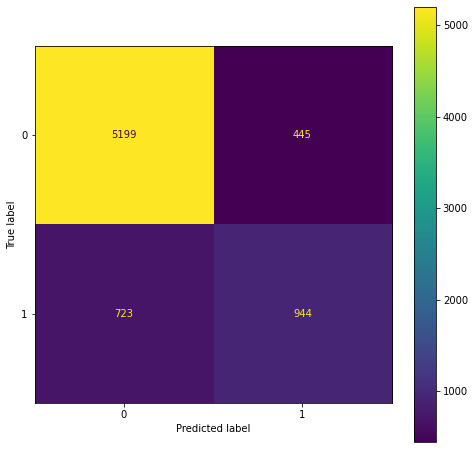

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(lr_clf, cls_test_features, cls_test_labels, ax=ax)  
plt.show()

Entity start architecture

In [44]:
ent_labels = [doc['entity_labels'] for doc in docs if 'entity_labels' in doc.keys()]
relation_labels = [doc['rel_labels'] for doc in docs if 'rel_labels' in doc.keys()]
e = list(itertools.chain.from_iterable(ent_labels))
r = list(itertools.chain.from_iterable(relation_labels))
print(len(e))
start_train_features, start_test_features, start_train_labels, start_test_labels = train_test_split(entity_embeddings, e[:64653])

64685


NameError: ignored

In [ ]:
lr_clf = LogisticRegression(solver='saga')
lr_clf.fit(start_train_features, start_train_labels)
lr_clf.score(start_test_features, start_test_labels)

print(classification_report(start_test_labels, lr_clf.predict(start_test_features)))

              precision    recall  f1-score   support

           0       0.74      0.98      0.84     11951
           1       0.38      0.04      0.07      4206

    accuracy                           0.73     16157
   macro avg       0.56      0.51      0.46     16157
weighted avg       0.65      0.73      0.64     16157



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


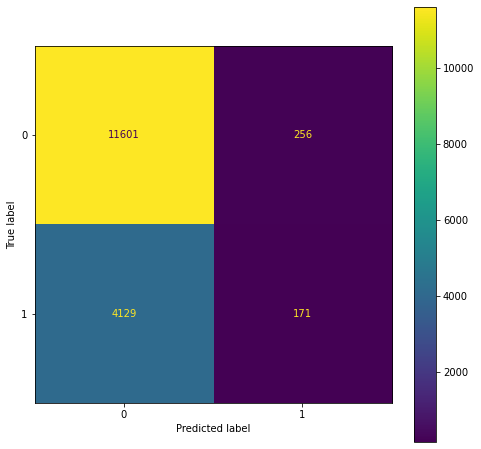

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(lr_clf, start_test_features, start_test_labels, ax=ax)  
plt.show()

In [ ]:
rel_labels = []
pos_embeddings = []
p = lr_clf.predict(start_test_features)
for elt in range(len(p)):
  if p[elt] ==1:
    pos_embeddings.append(entity_embeddings[elt])
    rel_labels.append(r[elt])

start_train_features, start_test_features, start_train_labels, start_test_labels = train_test_split(entity_embeddings, rel_labels)

#Defines a logistic regression classifier
lr_clf = LogisticRegression(solver='saga')

#Fits the model to the training data
lr_clf.fit(start_train_features, start_train_labels)

#Tests the model using the test data
lr_clf.score(start_test_features, start_test_labels)

print(classification_report(start_test_labels, lr_clf.predict(start_test_features)))

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(lr_clf, start_test_features, start_test_labels, ax=ax)  
plt.show()